In [3620]:
import pandas as pd
df = pd.read_csv("Matches.csv")

df = df.dropna(subset=["Broadcast Date"])

for i in range(len(df)):
    if df["Match Winner(s)"][i] == "-":
        df.drop(i, inplace=True)

df.reset_index(drop=True, inplace=True)

roster_list = []

for i in df["Match Loser(s)"]:
    if i not in roster_list:
        roster_list.append(i)

for i in df["Match Winner(s)"]:
    if i not in roster_list:
        roster_list.append(i)

In [3621]:
# Constants

adjustment_rate = 224
const_match = 9
starting_elo = 1095

In [3622]:
roster_dict = {}
for i in roster_list:
    roster_dict[i] = starting_elo
    
roster = pd.DataFrame.from_dict(roster_dict, orient="index")

roster.columns = ["Elo"]

roster.insert(1, "Number of Matches", 0)
roster.insert(2, "Max Elo", starting_elo)
roster.insert(3, "Min Elo", starting_elo)

In [3623]:
adj_a_list = []
adj_b_list = []
outliers_dict = {"Match": []}

In [3624]:
def find_adjustment(winner, loser, prob_winner, prob_loser, a_match, b_match, adjust=adjustment_rate, multicheck=False, i=0, const_match=const_match):
    l_length = 0
    adjust_a = 0
    adjust_b = 0
    if multicheck == False:
        pass
    else:
        p = str(df["Competitors"][i])
        q = winner.split(",")
        z = loser.split(",")
        if len(q) > 1:
            pass
        else:
            if len(z) > 6:
                print(f"Number of losers: {len(z)}, number of winners: {len(q)}")
            if len(z) > 1:
                loser = z[0]
        
        
            l = p.split(",")
            for i in range(100):
                try:
                    l.remove(" ")
                except ValueError:
                    break
                    

            l_length = len(l)
            l_length = l_length
        
    if l_length > 2:
        adjust_a = adjust * (1 - (prob_winner ** (1 / l_length)))
        adjust_b = adjust / (1 - (prob_loser ** (1 / l_length)))
    
    if a_match < const_match:
        adjust_a = (adjust)  * (const_match - a_match) * 2 + adjust_a

    else:
        adjust_a = adjust + adjust_a

            
    if b_match < const_match:
        adjust_b = adjust * (const_match - b_match) * 2 + adjust_b

        
    else:
        adjust_b = adjust + adjust_b

        
        

    return adjust_a, adjust_b


In [3625]:
def find_closest_roster(name):
    # Find lexical simularity of names
    if name in roster.index:
        return roster.index[roster.index == name]
    elif roster.index.str.contains(name).any():
        return roster.index[roster.index.str.contains(name)]
    else:
        name = name.split(" ")
        names = []
        for i in range(len(name)):
            names.append(roster.index[roster.index.str.contains(name[i])])
        return names

In [3626]:
def adjust_elo(winner, loser, elo_a=starting_elo, elo_b=starting_elo, a_match=0, b_match=0, i=0, multicheck=False, adjust=adjustment_rate):
    prob_winner = 1 / (1 + 10 ** ((elo_b - elo_a) / adjust))
    prob_loser = 1 / (1 + 10 ** ((elo_a - elo_b) / adjust))
    adjust=adjustment_rate
    
    adjust_a, adjust_b = find_adjustment(winner, loser, prob_winner, prob_loser, a_match, b_match, i=i, multicheck=multicheck)
    adjust_a = (adjust_a) * (1 - prob_winner)
    adjust_b = (adjust_b) * (1 - prob_loser)
    adj_a_list.append(adjust_a)
    adj_b_list.append(adjust_b)  
    elo_a = elo_a + (adjust_a) * (1 - prob_winner)
    elo_b = elo_b + (adjust_b) * (0 - prob_loser)
    if elo_b < 100:
        elo_b = 100
    a_match += 1
    b_match += 1
    
    if adjust_a > 300 or adjust_b > 300:
        outliers_dict["Match"].append({"Winner": winner, "Loser": loser, "Adjustment": [adjust_a, adjust_b]})
    return elo_a, elo_b

In [3627]:
def predict_winner(a, b):
    try:
        elo_a = roster.loc[a, "Elo"]
    except:
        new_a = find_closest_roster(a)
        print("Did you mean the following/one of the following {}?".format(new_a))
        user_input = input("Enter the name of the roster you meant, or type 'new' for someone not on the roster: ")
        if user_input == "new":
            elo_a = starting_elo
            a_match = 0
        else:
            elo_a = roster.loc[user_input, "Elo"]
            a = user_input
    
    try:
        elo_b = roster.loc[b, "Elo"]
    except:
        new_b = find_closest_roster(b)
        print("Did you mean the following/one of the following {}?".format(new_b))
        user_input = input("Enter the name of the roster you meant, or type 'new' for someone not on the roster: ")
        if user_input != "new":
            elo_b = roster.loc[user_input, "Elo"]
            b = user_input
        else:
            elo_b = starting_elo
            b_match = 0
    
    prob_a = 1 / (1 + 10 ** ((elo_b - elo_a) / 400))
    prob_b = 1 / (1 + 10 ** ((elo_a - elo_b) / 400))
    try:
        a_match = roster.loc[a, "Number of Matches"]
    except:
        pass
    try:
        b_match = roster.loc[b, "Number of Matches"]
    except:
        pass
    
    adjust_a, adjust_x = find_adjustment(a, b, prob_a, prob_b, a_match, b_match)
    adjust_b, adjust_y = find_adjustment(b, a, prob_b, prob_a, b_match, a_match)
    
    adjust_a = adjust_a * (1 - prob_a)
    adjust_x = adjust_x * (0 - prob_b)
    
    adjust_b = adjust_b * (1 - prob_b)
    adjust_y = adjust_y * (0 - prob_a)
    
    print("-"*50)
    print(f"""
          {a}'s Elo: {elo_a}
          Probability of {a} winning: {round(prob_a*100, 2)}%. 
          Rating change for win: {round(adjust_a)}.
          New rating after win: {round(elo_a + adjust_a)}. 
          Rating change for loss: {round(adjust_y)}.
          New rating after loss: {round(elo_a + adjust_y)}.""")
    print(f"""
          {b}'s Elo: {elo_b}
          Probability of {b} winning: {round(prob_b*100, 2)}%.
          Rating change for win: {round(adjust_b)}.
          New rating after win: {round(elo_b + adjust_b)}.
          Rating change for loss: {round(adjust_x)}.
          New rating after loss: {round(elo_b + adjust_x)}.""")

In [3628]:
x = 0
biggest_upset = 0
Winner = None
Loser = None
Initial_Winner_Elo = None
Initial_Loser_Elo = None
After_W_Elo = None
After_L_Elo = None
upsets_total = 0
match_total = 0
for i in range(len(df)):
    a = df["Match Winner(s)"][i]
    b = df["Match Loser(s)"][i]
    a_elo = roster.loc[a][0]
    b_elo = roster.loc[b][0]
    winner_elo, loser_elo = adjust_elo(a, b, a_elo, b_elo, roster.loc[a][1], roster.loc[b][1], i=i, multicheck=True)
    roster.iloc[roster_list.index(a), 0] = winner_elo
    roster.iloc[roster_list.index(b), 0] = loser_elo
    roster.iloc[roster_list.index(a), 1] += 1
    roster.iloc[roster_list.index(b), 1] += 1
    
    # Change Winner's Max ELO and Loser's Min ELO if applicable
    
    if winner_elo > roster.loc[a][2]:
        roster.iloc[roster_list.index(a), 2] = winner_elo
    
    if loser_elo < roster.loc[b][3]:
        roster.iloc[roster_list.index(b), 3] = loser_elo
    
    if (loser_elo - winner_elo) > 50:
        upsets_total += 1
    if (loser_elo - winner_elo) > biggest_upset:
        biggest_upset = loser_elo - winner_elo
        Winner = a
        Loser = b
        Initial_Winner_Elo = round(a_elo)
        Initial_Loser_Elo = round(b_elo)
        After_W_Elo = round(winner_elo)
        After_L_Elo = round(loser_elo)
    match_total += 1



Number of losers: 8, number of winners: 1
Number of losers: 20, number of winners: 1


C:\Users\perle\AppData\Local\Temp\ipykernel_23744\2568748423.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  adjust_b = adjust / (1 - (prob_loser ** (1 / l_length)))
C:\Users\perle\AppData\Local\Temp\ipykernel_23744\890822915.py:8: RuntimeWarning: invalid value encountered in double_scalars
  adjust_b = (adjust_b) * (1 - prob_loser)


Number of losers: 7, number of winners: 1


In [3629]:
roster

,Elo,Number of Matches,Max Elo,Min Elo
Sammy Guevara,4121.882632,53,4121.882635,100.0
"Strong Hearts (CIMA, El Lindaman & T-Hawk)",100.000000,2,1095.000000,100.0
"Awesome Kong, Kylie Rae, and Nyla Rose",100.000000,1,1095.000000,100.0
Angelico & Jack Evans,100.000000,2,1095.000000,100.0
"Aja Kong, Emi Sakura & Yuka Sakazaki",100.000000,1,1095.000000,100.0
...,...,...,...,...
Emi Sakura & Serena Deeb,1990.999957,2,1990.999957,1095.0
The Gunns (Austin Gunn & Colten Gunn),2103.000000,1,2103.000000,1095.0
Eddie Kingston & Ortiz,2103.000004,2,2103.000004,1095.0
The Blonds (Brian Pillman Jr. & Griff Garrison),5126.745006,1,5126.745006,1095.0


In [3630]:
print(f"""
        Biggest upset: {Winner} beating {Loser}.
        {Winner}'s Elo before the match: {Initial_Winner_Elo}.
        {Loser}'s Elo before the match: {Initial_Loser_Elo}.
        {Winner}'s Elo after the match: {After_W_Elo}.
        {Loser}'s Elo after the match: {After_L_Elo}.
        {Winner}'s Elo change: {After_W_Elo - Initial_Winner_Elo}.
        {Loser}'s Elo change: {After_L_Elo - Initial_Loser_Elo}.
        """)



        Biggest upset: The Young Bucks (Matt Jackson & Nick Jackson) beating FTR (Dax Harwood & Cash Wheeler).
        The Young Bucks (Matt Jackson & Nick Jackson)'s Elo before the match: 3036.
        FTR (Dax Harwood & Cash Wheeler)'s Elo before the match: 8168.
        The Young Bucks (Matt Jackson & Nick Jackson)'s Elo after the match: 3260.
        FTR (Dax Harwood & Cash Wheeler)'s Elo after the match: 8168.
        The Young Bucks (Matt Jackson & Nick Jackson)'s Elo change: 224.
        FTR (Dax Harwood & Cash Wheeler)'s Elo change: 0.
        


In [3631]:
roster.sort_values(by="Elo", ascending=False)

,Elo,Number of Matches,Max Elo,Min Elo
Darby Allin & Sting,9158.999999,3,9158.999999,1095.0
Jeff Hardy,8251.218910,3,8251.218996,1095.0
FTR (Dax Harwood & Cash Wheeler),8168.395026,41,8168.395026,1095.0
Andrade El Ídolo,7908.873995,17,7908.873995,1095.0
Will Ospreay,7844.514095,2,7844.514095,1095.0
...,...,...,...,...
"The Factory (QT Marshall, Aaron Solo & Nick Comoroto)",100.000000,1,1095.000000,100.0
"The Dark Order (Alex Reynolds, John Silver, & 10)",NaN,11,2103.000013,1095.0
"Death Triangle (PAC, Penta El Zero Miedo, & Rey Fénix)",NaN,6,5126.745006,1095.0
Best Friends (Chuck Taylor & Trent? Beretta) & Orange Cassidy,NaN,7,2935.411813,1095.0


In [3632]:
womens_singles = pd.read_csv("womens_singles.csv")

for i in range(len(womens_singles)):
    if womens_singles["Wrestler"][i] not in roster_list:
        pass
    else:
        womens_singles["Elo"][i] = roster.loc[womens_singles["Wrestler"][i]][0]
        womens_singles["Number of Matches"][i] = roster.loc[womens_singles["Wrestler"][i]][1]

mens_tag = pd.read_csv("mens_tag.csv")

for i in range(len(mens_tag)):
    if mens_tag["Tag Team"][i] not in roster_list:
        pass
    else:
        mens_tag["Elo"][i] = roster.loc[mens_tag["Tag Team"][i]][0]
        mens_tag["Number of Matches"][i] = roster.loc[mens_tag["Tag Team"][i]][1]

mens_trios = pd.read_csv("mens_trios.csv")


for i in range(len(mens_trios)):
    if mens_trios["Tag Team"][i] not in roster_list:
        pass
    else:
        mens_trios["Elo"][i] = roster.loc[mens_trios["Tag Team"][i]][0]
        mens_trios["Number of Matches"][i] = roster.loc[mens_trios["Tag Team"][i]][1]

womens_tag = pd.read_csv("womens_tag.csv")


for i in range(len(womens_tag)):
    if womens_tag["Tag Team"][i] not in roster_list:
        pass
    else:
        womens_tag["Elo"][i] = roster.loc[womens_tag["Tag Team"][i]][0]
        womens_tag["Number of Matches"][i] = roster.loc[womens_tag["Tag Team"][i]][1]
        
mens_singles = pd.read_csv("mens_singles.csv")

for i in range(len(mens_singles)):
    if mens_singles["Wrestler"][i] not in roster_list:
        pass
    else:
        mens_singles["Elo"][i] = roster.loc[mens_singles["Wrestler"][i]][0]
        mens_singles["Number of Matches"][i] = roster.loc[mens_singles["Wrestler"][i]][1]


# Transfer the max and min elo to the individual groups

for i in range(len(mens_singles)):
    mens_singles.reset_index(drop=True, inplace=True)
    mens_singles["Max Elo"][i] = roster.loc[roster.index == mens_singles["Wrestler"][i]]["Max Elo"].values
    mens_singles["Min Elo"][i] = roster.loc[roster.index == mens_singles["Wrestler"][i]]["Min Elo"].values
    
for i in range(len(womens_singles)):
    womens_singles.reset_index(drop=True, inplace=True)
    womens_singles["Max Elo"][i] = roster.loc[roster.index == womens_singles["Wrestler"][i]]["Max Elo"].values
    womens_singles["Min Elo"][i] = roster.loc[roster.index == womens_singles["Wrestler"][i]]["Min Elo"].values
    
for i in range(len(mens_tag)):
    mens_tag.reset_index(drop=True, inplace=True)
    mens_tag["Max Elo"][i] = roster.loc[roster.index == mens_tag["Tag Team"][i]]["Max Elo"].values
    mens_tag["Min Elo"][i] = roster.loc[roster.index == mens_tag["Tag Team"][i]]["Min Elo"].values
    
for i in range(len(mens_trios)):
    mens_trios.reset_index(drop=True, inplace=True)
    mens_trios["Max Elo"][i] = roster.loc[roster.index == mens_trios["Tag Team"][i]]["Max Elo"].values
    mens_trios["Min Elo"][i] = roster.loc[roster.index == mens_trios["Tag Team"][i]]["Min Elo"].values

for i in range(len(womens_tag)):
    womens_tag.reset_index(drop=True, inplace=True)
    womens_tag["Max Elo"][i] = roster.loc[roster.index == womens_tag["Tag Team"][i]]["Max Elo"].values
    womens_tag["Min Elo"][i] = roster.loc[roster.index == womens_tag["Tag Team"][i]]["Min Elo"].values

C:\Users\perle\AppData\Local\Temp\ipykernel_23744\24978312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  womens_singles["Elo"][i] = roster.loc[womens_singles["Wrestler"][i]][0]
C:\Users\perle\AppData\Local\Temp\ipykernel_23744\24978312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  womens_singles["Number of Matches"][i] = roster.loc[womens_singles["Wrestler"][i]][1]
C:\Users\perle\AppData\Local\Temp\ipykernel_23744\24978312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [3633]:
womens_singles.sort_values(by="Elo", ascending=False)
# Print the elo of Jade Cargill
print(roster.loc["Jade Cargill"][0])

3442.6339820526173


In [3634]:
womens_singles.drop(womens_singles[womens_singles["Number of Matches"] == 0].index, inplace=True)
women_singles = womens_singles.sort_values(by="Elo", ascending=False)
womens_singles.to_csv("womens_singles.csv", index=False)

mens_tag.drop(mens_tag[mens_tag["Number of Matches"] == 0].index, inplace=True)
mens_tag = mens_tag.sort_values(by="Elo", ascending=False)
mens_tag.to_csv("mens_tag.csv", index=False)

mens_trios.drop(mens_trios[mens_trios["Number of Matches"] == 0].index, inplace=True)
mens_trios = mens_trios.sort_values(by="Elo", ascending=False)
mens_trios.to_csv("mens_trios.csv", index=False)

womens_tag.drop(womens_tag[womens_tag["Number of Matches"] == 0].index, inplace=True)
women_tag = womens_tag.sort_values(by="Elo", ascending=False)
womens_tag.to_csv("womens_tag.csv", index=False)

mens_singles.drop(mens_singles[mens_singles["Number of Matches"] == 0].index, inplace=True)
mens_singles = mens_singles.sort_values(by="Elo", ascending=False)
mens_singles.to_csv("mens_singles.csv", index=False)

mens_singles.to_csv("mens_singles.csv", index=False)
mens_trimmed = mens_singles

In [3635]:
inactive_list = []
active_list = []
for i in range(len(roster)):
    if roster["Number of Matches"][i] == 0:
        inactive_list.append(roster.index[i])
for i in range(len(df)-150, len(df)):
    a = df["Match Winner(s)"][i]
    b = df["Match Loser(s)"][i]
    active_list.append(a)
    active_list.append(b)
    
for i in range(len(df)):
    a = df["Match Winner(s)"][i]
    b = df["Match Loser(s)"][i]
    if a not in active_list:
        inactive_list.append(a)
    if b not in active_list:
        inactive_list.append(b)


In [3636]:
Title_Holders = ["Chris Jericho", "Jon Moxley", "Orange Cassidy", "Wardlow", "HOOK"]

In [3637]:

# Drop inactive wrestlers from Mens Trimmed
mens_trimmed.drop(mens_trimmed[mens_trimmed["Wrestler"].isin(inactive_list)].index, inplace=True)
mens_trimmed = mens_trimmed.sort_values(by="Elo", ascending=False)
mens_trimmed.reset_index(drop=True, inplace=True)

womens_trimmed = womens_singles
womens_trimmed.drop(womens_trimmed[womens_trimmed["Wrestler"].isin(inactive_list)].index, inplace=True)
womens_trimmed = womens_trimmed.sort_values(by="Elo", ascending=False)
womens_trimmed.reset_index(drop=True, inplace=True)

mens_tag_trimmed = mens_tag
mens_tag_trimmed.drop(mens_tag_trimmed[mens_tag_trimmed["Tag Team"].isin(inactive_list)].index, inplace=True)
mens_tag_trimmed = mens_tag_trimmed.sort_values(by="Elo", ascending=False)
mens_tag_trimmed.reset_index(drop=True, inplace=True)

mens_trios_trimmed = mens_trios
mens_trios_trimmed.drop(mens_trios_trimmed[mens_trios_trimmed["Tag Team"].isin(inactive_list)].index, inplace=True)
mens_trios_trimmed = mens_trios_trimmed.sort_values(by="Elo", ascending=False)
mens_trios_trimmed.reset_index(drop=True, inplace=True)

womens_tag_trimmed = womens_tag
womens_tag_trimmed.drop(womens_tag_trimmed[womens_tag_trimmed["Tag Team"].isin(inactive_list)].index, inplace=True)
womens_tag_trimmed = womens_tag_trimmed.sort_values(by="Elo", ascending=False)
womens_tag_trimmed.reset_index(drop=True, inplace=True)

In [3638]:
mens_trimmed.to_csv("trimmed/mens_trimmed.csv", index=False)
womens_trimmed.to_csv("trimmed/womens_trimmed.csv", index=False)
mens_tag_trimmed.to_csv("trimmed/mens_tag_trimmed.csv", index=False)
mens_trios_trimmed.to_csv("trimmed/mens_trios_trimmed.csv", index=False)
womens_tag_trimmed.to_csv("trimmed/womens_tag_trimmed.csv", index=False)

In [3639]:
mens_trimmed.reset_index(drop=True, inplace=True)
mens_trimmed
# Create a list of contenders for the title by dropping the title holders from the mens_trimmed list
contenders = mens_trimmed[~mens_trimmed["Wrestler"].isin(Title_Holders)]
contenders.reset_index(drop=True, inplace=True)

In [3640]:
contenders[0:10]

,Wrestler,Elo,Max Elo,Min Elo,Number of Matches
0,Bryan Danielson,5896.769909,5949.855438,1095.0,31
1,Frankie Kazarian,5884.793643,5905.117661,1095.0,47
2,MJF,5794.479934,5843.452158,1095.0,28
3,Adam Page,5703.606905,5759.373064,1095.0,41
4,Claudio Castagnoli,5540.541941,5687.027085,1095.0,8
5,PAC,5510.001849,5523.596620,1095.0,36
6,Darby Allin,5399.527640,5399.527645,1095.0,65
7,Lance Archer,5183.187133,5237.153923,1095.0,63
8,Rush,5121.067338,5127.000000,1095.0,5
9,Dante Martin,4958.406398,4958.875854,1095.0,54


(array([379.,  40., 844.,  22., 302.,  23.,  21.,  36.,  19.,  22.,  28.,
         98.,  14.,   6.,   4.,   2.,   0.,   5.,   0.,   1.]),
 array([ 100.        ,  552.94999993, 1005.89999985, 1458.84999978,
        1911.7999997 , 2364.74999963, 2817.69999956, 3270.64999948,
        3723.59999941, 4176.54999934, 4629.49999926, 5082.44999919,
        5535.39999911, 5988.34999904, 6441.29999897, 6894.24999889,
        7347.19999882, 7800.14999875, 8253.09999867, 8706.0499986 ,
        9158.99999852]),
 <BarContainer object of 20 artists>)

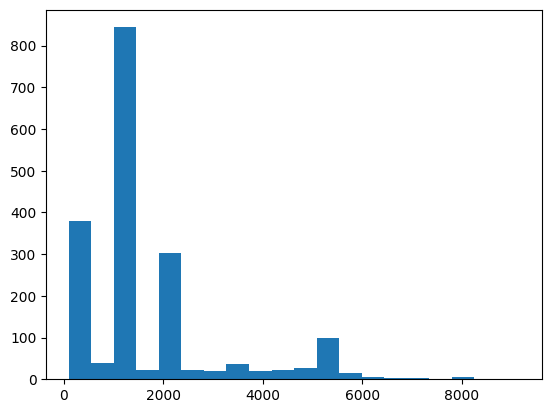

In [3641]:
import matplotlib.pyplot as plt
# create a bell curve of the mens singles elo
plt.hist(roster["Elo"], bins=20)


In [3642]:
#Stats
avg = roster["Elo"].mean()
std_dev = roster["Elo"].std()
outliers = roster[roster["Elo"] > avg + 3 * std_dev]
outliers = outliers.append(roster[roster["Elo"] < avg - 3 * std_dev])


C:\Users\perle\AppData\Local\Temp\ipykernel_23744\1028574157.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(roster[roster["Elo"] < avg - 3 * std_dev])


In [3643]:
print(f"The average elo is {avg}")
print(f"The standard deviation is {std_dev}")


The average elo is 1582.0831303783789
The standard deviation is 1450.7708430438167


In [3644]:
#track accuracy of elo system
correct = 0
incorrect = 0
for i in range(len(df)):
    a = df["Match Winner(s)"][i]
    b = df["Match Loser(s)"][i]

    a_elo = roster.loc[roster.index == a]["Elo"].values
    b_elo = roster.loc[roster.index == b]["Elo"].values
    if a_elo > b_elo:
        correct += 1
    else:
        incorrect += 1

In [3645]:
predict_winner("Jon Moxley", "MJF")

--------------------------------------------------

          Jon Moxley's Elo: 6362.175043590905
          Probability of Jon Moxley winning: 96.33%. 
          Rating change for win: 8.
          New rating after win: 6370. 
          Rating change for loss: -216.
          New rating after loss: 6146.

          MJF's Elo: 5794.479934070677
          Probability of MJF winning: 3.67%.
          Rating change for win: 216.
          New rating after win: 6010.
          Rating change for loss: -8.
          New rating after loss: 5786.


In [3646]:
mens_singles.sort_values(by="Elo", ascending=False)

,Wrestler,Elo,Max Elo,Min Elo,Number of Matches
8,Jon Moxley,6362.175044,6362.193233,1095.000000,66
10,Chris Jericho,5979.146915,5979.146915,1095.000000,34
11,Bryan Danielson,5896.769909,5949.855438,1095.000000,31
12,Frankie Kazarian,5884.793643,5905.117661,1095.000000,47
13,MJF,5794.479934,5843.452158,1095.000000,28
...,...,...,...,...,...
343,Baron Black,446.283991,1095.000000,222.331458,25
351,Bshp King,357.769237,1095.000000,357.769237,3
354,Gus De La Vega,310.886875,1095.000000,310.886875,3
370,Caleb Konley,100.000000,1095.000000,100.000000,2


In [3647]:
#Stats
avg = mens_singles["Elo"].mean()
std_dev = mens_singles["Elo"].std()
outliers = mens_singles[mens_singles["Elo"] > avg + 3 * std_dev]
outliers = outliers.append(mens_singles[mens_singles["Elo"] < avg - 3 * std_dev])

C:\Users\perle\AppData\Local\Temp\ipykernel_23744\4160555235.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(mens_singles[mens_singles["Elo"] < avg - 3 * std_dev])


In [3648]:
print(f"The average elo of the mens division is {round(avg)}")
print(f"The standard deviation is {round(std_dev)}")
print(f"The lowest elo is {round(mens_singles['Elo'].min())} which is {mens_singles[mens_singles['Elo'] == mens_singles['Elo'].min()]['Wrestler'].values[0]}'s rating")
print(f"The highest elo is {round(mens_singles['Elo'].max())} which is {mens_singles[mens_singles['Elo'] == mens_singles['Elo'].max()]['Wrestler'].values[0]}'s rating")

The average elo of the mens division is 2938
The standard deviation is 1902
The lowest elo is 100 which is Caleb Konley's rating
The highest elo is 6362 which is Jon Moxley's rating


Text(0.5, 0, 'Number of Matches')

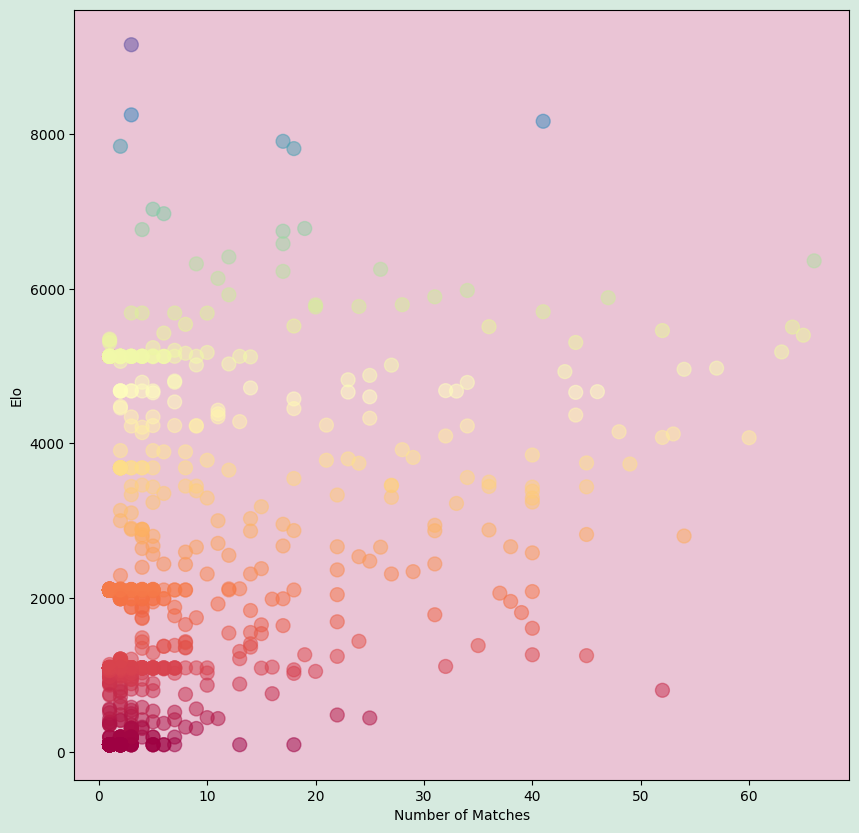

In [3649]:
# Make a scatter plot of the roster
plot = plt.figure(figsize=(10, 10))
ax = plt.gca()
plot.set_facecolor("#d6eadf")
ax.set_facecolor("#eac4d5")
ax.scatter(roster["Number of Matches"], roster["Elo"], cmap="Spectral", c=roster["Elo"], s=100, alpha=0.5)
ax.set_ylabel("Elo")
ax.set_xlabel("Number of Matches")


In [3650]:
# Find biggest range of max and min elo in roster
elo_range = 0
max_wrestler = ""
t_max_elo = 0
t_min_elo = 0
mens_singles.reset_index(drop=True, inplace=True)

for i in range(len(mens_singles)):
    wrestler = mens_singles["Wrestler"][i]
    max_elo = mens_singles["Max Elo"][i]
    min_elo = mens_singles["Min Elo"][i]
    if min_elo == starting_elo:
        pass
    else:
        if diff > elo_range:
            elo_range = diff
            max_wrestler = wrestler
            t_max_elo = max_elo
            t_min_elo = min_elo
            t_current_elo = mens_singles["Elo"][i]


print(f"{max_wrestler} has the biggest range of {round(elo_range)}")
print(f"{max_wrestler}'s max elo is {round(t_max_elo)}")
print(f"{max_wrestler}'s min elo is {round(t_min_elo)}")
print(f"{max_wrestler}'s current elo is {round(t_current_elo)}")

        


Dante Martin has the biggest range of 868
Dante Martin's max elo is 4959
Dante Martin's min elo is 1095
Dante Martin's current elo is 4958


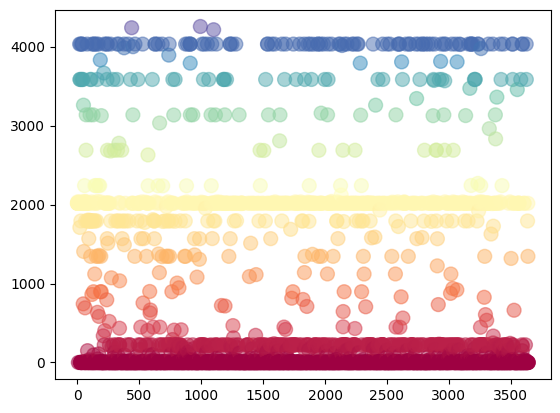

In [3651]:
plt.scatter([i for i in range(len(adj_a_list))], adj_a_list, cmap="Spectral", c=adj_a_list, s=100, alpha=0.5)



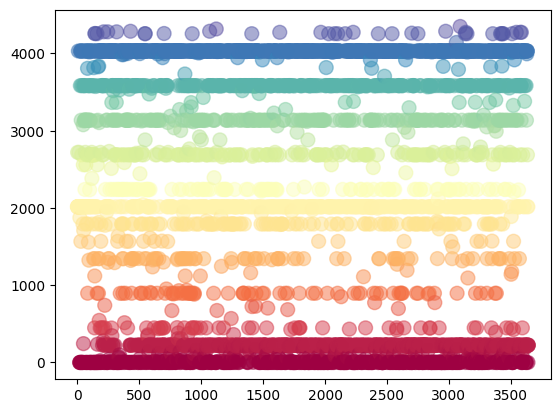

In [3652]:
plt.scatter([i for i in range(len(adj_b_list))], adj_b_list, cmap="Spectral", c=adj_b_list, s=100, alpha=0.5)

In [3653]:
print("Concurrent testing:")
print(f"{upsets_total} out of {match_total} matches were upsets. This is {round(upsets_total/match_total * 100, 2)}% of matches.")

print("Back testing:")
print(f"{incorrect} out of {correct+incorrect} matches were incorrect. This is {round(incorrect/(correct+incorrect)*100, 2)}% of the time")

Concurrent testing:
267 out of 3642 matches were upsets. This is 7.33% of matches.
Back testing:
366 out of 3642 matches were incorrect. This is 10.05% of the time


(array([246., 687., 981., 879., 870., 772., 769., 686., 616., 592., 563.,
        492., 412., 351., 363., 244., 207., 144.,  88.,  38.]),
 array([1.03311819, 1.47974254, 1.92636689, 2.37299123, 2.81961558,
        3.26623993, 3.71286428, 4.15948863, 4.60611297, 5.05273732,
        5.49936167, 5.94598602, 6.39261037, 6.83923471, 7.28585906,
        7.73248341, 8.17910776, 8.62573211, 9.07235645, 9.5189808 ,
        9.96560515]),
 <BarContainer object of 20 artists>)

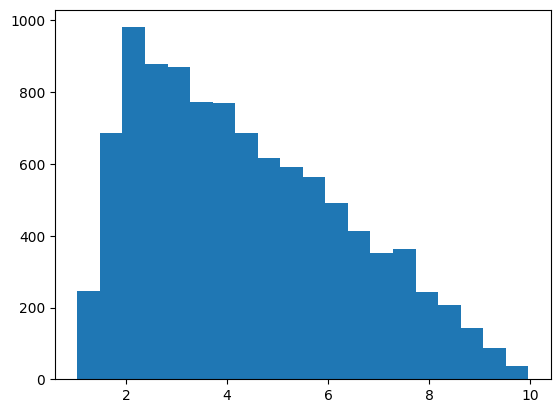

In [3654]:
import numpy as np
np.random.triangular(1, 2, 1000)
x_list = []
for i in range(10000):
    x = np.random.triangular(1, 2, 10)
    x_list.append(x)
    
plt.hist(x_list, bins=20)
    
